## Applying ToMe to timm models
A quick example showing how to apply ToMe to a timm model off-the-shelf.

In [ ]:
import timm
import tome
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

In [2]:
# Use any ViT model here (see timm.models.vision_transformer)
model_name = "vit_base_patch16_224"

# Load a pretrained model
model = timm.create_model(model_name, pretrained=True)

In [3]:
input_size = model.default_cfg["input_size"][1]

transform = transforms.Compose([
    transforms.Resize(int((256 / 224) * input_size), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(model.default_cfg["mean"], model.default_cfg["std"]),
])

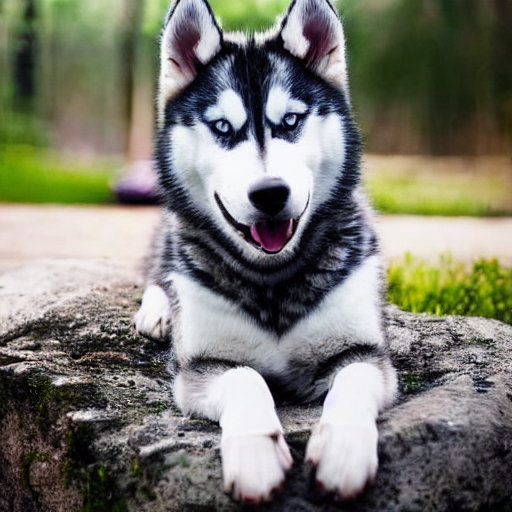

In [4]:
img = Image.open("images/husky.png")
img_tensor = transform(img)[None, ...]

img  # Note: image generated with stable diffusion

In [5]:
# Run the image through the baseline model
# 248: Eskimo dog, husky
# 249: malamute, malemute, Alaskan malamute
# 250: Siberian husky
model(img_tensor).topk(5).indices[0].tolist()

[248, 250, 249, 269, 273]

### Applying ToMe
Simply patch the model after initialization to enable ToMe.

In [6]:
# Patch the model with ToMe
tome.patch.timm(model)

In [7]:
# Run the model with no reduction (should be the same as before)
model.r = 0
model(img_tensor).topk(5).indices[0].tolist()

[248, 250, 249, 269, 273]

In [10]:
# Run the model with some reduction
# Only the least applicable class changed
model.r = 8
model(img_tensor).topk(5).indices[0].tolist()

[248, 250, 249, 269, 537]

In [11]:
# Run the model with a lot of reduction
# Top-3 most applicable classes didn't change (husky, Siberian husky, Alaskan malamute)
# But model is 2x faster now! See 1_benchmark_timm.ipynb
model.r = 16
model(img_tensor).topk(5).indices[0].tolist()

[248, 250, 249, 537, 269]